# Cell-coupled GLM

By Charles Xu @ DJA Lab, Caltech

## Set up environment

In [3]:
# Import packages
import sys
if '/Users/alveus/Documents/WorkingDirectory/Packages/Python' not in sys.path:
    sys.path.insert(0, '/Users/alveus/Documents/WorkingDirectory/Packages/Python')

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io as sio

import statsmodels.api as sm

from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA

# import ssm
# from ssm.util import find_permutation

### User inputs

In [4]:
# User inputs
data_path = r'/Users/alveus/Documents/WorkingDirectory/Data/DJA/Jineun/PythonData/EG1-4/priority_malemale' # Path to data on my Mac
data_name_fasted = r'EG1-4_fasted.mat'
data_name_fed = r'EG1-4_fed.mat'
frame_rate = 10 # Frame rate of the data (in Hz)
time_window = 5 # Time window for regressors (in seconds)
time_step = 5 # Time step for the regressors (in frames)
n_folds = 5 # Number of folds for cross-validation
good_beta_threshold = 0.5 # Threshold for good betas as a proportion of the maximum beta
exp_condition = 'fasted' # 'fasted' or 'fed'

### Load data

In [5]:
# Load data
if exp_condition == 'fasted':
    data_fullfile = data_path + '/' + data_name_fasted
elif exp_condition == 'fed':
    data_fullfile = data_path + '/' + data_name_fed
else:
    sys.exit('Error: exp_condition should be either fasted or fed')
mat = sio.loadmat(data_fullfile)
input_raw = mat['behaviorFullMaFPS']
output_raw = np.array(mat['neural_ref'])
# output_raw = np.array(mat['neural_data_fed_0703'])
labels_raw = mat['behaviorNames']
labels = []
for i in range(len(labels_raw)):
    labels.append(labels_raw[i][0][0])

## Processing data

### Process variables

In [6]:
# Define function to smooth data
def smooth(data, window_size):
    '''
    data: ndarray of size (n_samples, )
        Raw trace to be smoothed
    window_size: int
        Size of the smoothing window (in frames)
    '''
    smoothed = np.convolve(data, np.ones(window_size+1, dtype=int) / window_size, 'valid')
    r = np.arange(1, window_size, 2)
    start = np.cumsum(data[:window_size])[::2]/r
    stop = (np.cumsum(data[:-window_size:-1])[::2]/r)[::-1]
    return np.concatenate((start, smoothed, stop))

In [7]:
# Process variables
output_smoothed = np.zeros_like(output_raw)
smooth_window = int(frame_rate * 2) # Window size for smoothing (2 seconds)
for i in range(output_raw.shape[0]):
    output_smoothed[i] = smooth(output_raw[i], smooth_window)

# del labels[2] # Leave out variable labels
input_labeled = {label: input_raw[i] for i, label in enumerate(labels)} # Create dictionary of input variables with labels

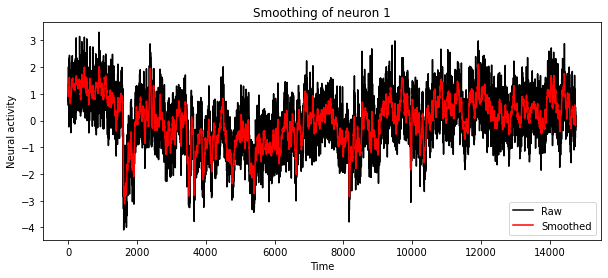

In [8]:
# Plot smoothing
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(output_raw[0, :], color='k', label='Raw')
ax.plot(output_smoothed[0, :], color='r', label='Smoothed')
ax.set_xlabel('Time')
ax.set_ylabel('Neural activity')
ax.set_title(f'Smoothing of neuron 1')
ax.legend()

### Make design matrix

In [9]:
output_raw.shape

(73, 14759)

In [20]:
# Define function to make the design matrix
def make_design_matrix_cell_coupled(input_vars, neural_activity, n_shifts):
    """
    input_vars: ndarray of shape (num_variables, num_samples)
        Input data
    output_vars: ndarray of shape (num_neurons, num_samples)
        Output data
    time_window: int
        Time window for design matrix (plus or minus) (in seconds)
    frame_rate: int
        Frame rate of the data (in Hz)
    time_step: int
        Time step for the regressors (in frames)
    """
    n_inputs = input_vars.shape[0]
    n_neurons = neural_activity.shape[0]
    design_matrix = np.zeros(((n_inputs+n_neurons)*(2*n_shifts+1), input_vars.shape[1])) # Initialize design matrix

    for i in range(n_inputs):
        for j in range(-time_window*frame_rate, time_window*frame_rate+1, time_step):
            if j < 0:
                design_matrix[i*(n_shifts*2+1)+j//time_step+n_shifts, :j] = input_vars[i,-j:] # Fill in the design matrix by shifting before
            elif j == 0:
                design_matrix[i*(n_shifts*2+1)+j//time_step+n_shifts, :] = input_vars[i,:] # Fill in the design matrix at the center
            else:
                design_matrix[i*(n_shifts*2+1)+j//time_step+n_shifts, j:] = input_vars[i,:-j] # Fill in the design matrix by shifting after
    for i in np.arange(n_neurons):
        for j in range(-time_window*frame_rate, time_window*frame_rate+1, time_step):
            if j < 0:
                design_matrix[(i+n_inputs)*(n_shifts*2+1)+j//time_step+n_shifts, :j] = neural_activity[i,-j:] # Fill in the design matrix by shifting before
            elif j == 0:
                design_matrix[(i+n_inputs)*(n_shifts*2+1)+j//time_step+n_shifts, :] = neural_activity[i,:] # Fill in the design matrix at the center
            else:
                design_matrix[(i+n_inputs)*(n_shifts*2+1)+j//time_step+n_shifts, j:] = neural_activity[i,:-j] # Fill in the design matrix by shifting after
    return design_matrix.T

In [17]:
# # Define function to make the design matrix
# def make_design_matrix_cell_coupled(input_vars, neural_activity, time_window, frame_rate, time_step):
#     """
#     input_vars: ndarray of shape (num_variables, num_samples)
#         Input data
#     neural_activity: ndarray of shape (num_neurons, num_samples)
#         Output data
#     time_window: int
#         Time window for design matrix (plus or minus) (in seconds)
#     frame_rate: int
#         Frame rate of the data (in Hz)
#     time_step: int
#         Time step for the regressors (in frames)
#     """
#     n_inputs = input_vars.shape[0]
#     n_neurons = neural_activity.shape[0]
#     n_shifts = int(time_window * frame_rate // time_step) # Number of shifts in either direction
#     design_matrix = np.zeros((input_vars.shape[1], (n_inputs+n_neurons)*(2*n_shifts+1), n_neurons)) # Initialize design matrix

#     for i in range(n_neurons):
#         for j in range(n_inputs):
#             for k in range(-time_window*frame_rate, time_window*frame_rate+1, time_step):
#                 if k < 0:
#                     design_matrix[:k, j*(n_shifts*2+1)+k//time_step+n_shifts, i] = input_vars[j,-k:] # Fill in the design matrix by shifting before
#                 elif k == 0:
#                     design_matrix[:, j*(n_shifts*2+1)+k//time_step+n_shifts, i] = input_vars[j,:] # Fill in the design matrix at the center
#                 else:
#                     design_matrix[k:, j*(n_shifts*2+1)+k//time_step+n_shifts, i] = input_vars[j,:-k] # Fill in the design matrix by shifting after
#         other_neurons = np.delete(neural_activity, i, axis=0)
#         for j in range(n_neurons-1):
#             for k in range(-time_window*frame_rate, time_window*frame_rate+1, time_step):
#                 if k < 0:
#                     design_matrix[:k, (n_inputs+j)*(n_shifts*2+1)+k//time_step+n_shifts, i] = other_neurons[j,-k:] # Fill in the design matrix by shifting before
#                 elif k == 0:
#                     design_matrix[:, (n_inputs+j)*(n_shifts*2+1)+k//time_step+n_shifts, i] = other_neurons[j,:] # Fill in the design matrix at the center
#                 else:
#                     design_matrix[k:, (n_inputs+j)*(n_shifts*2+1)+k//time_step+n_shifts, i] = other_neurons[j,:-k] # Fill in the design matrix by shifting after
#     return design_matrix

In [22]:
# Make the design matrix
n_shifts = int(time_window * frame_rate // time_step) # Number of regressors in either direction
x = make_design_matrix_cell_coupled(input_raw, output_smoothed, n_shifts)
y = output_smoothed.T
n_inputs = input_raw.shape[0] # Number of input variables
xd = x.shape[1] # Number of features ((n_inputs+n_neurons)*(2*n_shifts+1)
yd = y.shape[1] # Number of neurons
tt = x.shape[0] # Total time points
print(f'Features of x: {xd}')
print(f'Features of y: {yd}')
print(f'Total time points: {tt}')

Features of x: 1806
Features of y: 73
Total time points: 14759


## Fit GLMs

In [23]:
# Set up k-fold cross-validation
kf = KFold(n_splits=n_folds, shuffle=True, random_state=0) # Initialize KFold object, with deterministic output

### Fit using ridge regression which penalizes $\beta$ by $L_2$ regularization

#### Determine the best complexity parameter, $\alpha$, using grid search CV

In [29]:
# Set up grid search CV
alpha_test_range = 10**np.linspace(-10,9,50) # Get search values for alpha on log scale

fit_intercept = False # If y is mean-centered, set to False
# alpha_per_target = True # Allow every neuron to be regularized individualy for better model performance

# Perform grid search CV using RidgeCV
ridge_grid_search = linear_model.RidgeCV(alphas=alpha_test_range, fit_intercept=fit_intercept, scoring='r2', store_cv_values=True)
alphas = np.zeros(yd) # Initialize array to store alphas
for i in range(yd):
    xi = x
    xi[:,(i+n_inputs)*(n_shifts*2+1):(i+n_inputs+1)*(n_shifts*2+1)] = 0 # Set the regressors for the current neuron to be zero
    ridge_grid_search.fit(xi,y[:,i]) # Fit the model for each neuron
    alphas[i] = ridge_grid_search.alpha_

KeyboardInterrupt: 

In [ ]:
alphas

array([7.19685673, 7.19685673, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [ ]:
# Distribution of best alphas
fig,ax = plt.subplots()
ax.hist(alphas, bins=alpha_test_range)
ax.set_xscale('log')
ax.set_xlabel('Best alpha value')
ax.set_ylabel('Count')

#### Fit ridge regression

In [ ]:
# Fit ridge regression model
ridgereg = linear_model.Ridge(alpha=alphas, fit_intercept=fit_intercept) # Initialize Ridge object

betas_ridge = np.zeros((yd, xd, n_folds)) # Initialize betas matrix
r2_ridge = np.zeros((yd, n_folds)) # Initialize r2 matrix

for i, (train_index, test_index) in enumerate(kf.split(x)): # Loop through folds
    x_train, x_test = x[train_index], x[test_index] # Split x into train and test sets
    y_train, y_test = y[train_index], y[test_index] # Split y into train and test sets

    ridgereg.fit(x_train, y_train) # Fit ridge regression model
    betas_ridge[:,:,i] = ridgereg.coef_ # Store betas

    y_pred = ridgereg.predict(x_test) # Predict y
    r2_ridge[:,i] = r2_score(y_test, y_pred, multioutput='raw_values') # Calculate R2

betas_ridge = np.mean(betas_ridge, axis=2) # Average betas across folds
r2_ridge = np.mean(r2_ridge, axis=1) # Average R2 across folds